In [16]:
import os
import json
import numpy as np
import torch
# from tqdm import tqdm
import imageio as imageio
import copy
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import math
np.random.seed(0)
SUBIMAGES = [x for x in range(16)]#[1,2,5,6,9,10, 13,14]
cnt_pixels = 0.0
def get_comap(num_lens, d_lens_sensor, H, W):
#     global dim_lens_lf_yx
    dim_yx = [H,W] 
    dx = 0.020  # pixel size in mm
    # num_lenses_yx = [6,7]
    if math.sqrt(num_lens)**2 == num_lens:
        # print(math.sqrt(num_lens), num_lens)
        num_lenses_yx = [int(math.sqrt(num_lens)),int(math.sqrt(num_lens))] 
    else:
        print('Number of sublens should be a square number')
        assert False

    d_lens_sensor_lf = 10  # distance between lens array and sensor when no multiplexing (lightfield), in mm
    dim_lens_lf_yx = [dim_yx[0]//num_lenses_yx[0], dim_yx[0]//num_lenses_yx[0]] # number of pixels corresponding to a microlens at the lightfield situation
    d_lenses = dim_lens_lf_yx[0]*dx # # distance between the centers of adjacent microlenses, in mm

    # d_lens_sensor = FLAGS.d_lens_sensor  # this is the value to change for more or less multiplexing

    # print(f'd_lenses {d_lenses}, dim_lens_lf_yx {dim_lens_lf_yx}, d_lens_sensor {d_lens_sensor}')

    lenses_loc_yx = np.meshgrid((np.arange(num_lenses_yx[0]) - (num_lenses_yx[0]-1)/2) * d_lenses,
                                (np.arange(num_lenses_yx[1]) - (num_lenses_yx[1]-1)/2) * d_lenses, indexing='ij')
    lenses_loc_yx = np.array(lenses_loc_yx).reshape(2, np.prod(num_lenses_yx)).transpose()

    dim_lens_yx = [dim_lens_lf_yx[0] / d_lens_sensor_lf * d_lens_sensor, dim_lens_lf_yx[1] / d_lens_sensor_lf * d_lens_sensor]
    dim_lens_yx = [dim_lens_yx[0] - dim_lens_yx[0]%2, dim_lens_yx[1] - dim_lens_yx[1]%2]  # assuming dim_lens_yx is even
    lens_sensor_ind_yx = np.array(np.meshgrid(np.arange(dim_lens_yx[0]), np.arange(dim_lens_yx[1]), indexing='ij')).transpose((1, 2, 0))

    sensor_pixel_loc_y = (np.arange(dim_yx[0]) - dim_yx[0]/2) * dx
    sensor_pixel_loc_x = (np.arange(dim_yx[1]) - dim_yx[1]/2) * dx

    comap_yx = -np.ones((len(lenses_loc_yx), dim_yx[0], dim_yx[1], 2))  

    for i, lens_loc_yx in enumerate(lenses_loc_yx):
        center_index_yx = [np.argmin(np.abs(lens_loc_yx[0] - sensor_pixel_loc_y)), np.argmin(np.abs(lens_loc_yx[1] - sensor_pixel_loc_x))]
        start_index_sensor_yx = [np.maximum(0, center_index_yx[0] - dim_lens_yx[0]//2).astype(int),
                                 np.maximum(0, center_index_yx[1] - dim_lens_yx[1]//2).astype(int)]
        end_index_sensor_yx = [np.minimum(dim_yx[0], center_index_yx[0] + dim_lens_yx[0]//2).astype(int),
                               np.minimum(dim_yx[1], center_index_yx[1] + dim_lens_yx[1]//2).astype(int)]  

        start_index_lens_yx = [int(dim_lens_yx[0]//2 - center_index_yx[0] + start_index_sensor_yx[0]), 
                               int(dim_lens_yx[1]//2 - center_index_yx[1] + start_index_sensor_yx[1])]
        end_index_lens_yx = [int(dim_lens_yx[0]//2 - center_index_yx[0] + end_index_sensor_yx[0]), 
                             int(dim_lens_yx[1]//2 - center_index_yx[1] + end_index_sensor_yx[1])]

        comap_yx[i, start_index_sensor_yx[0]:end_index_sensor_yx[0], start_index_sensor_yx[1]:end_index_sensor_yx[1], :] = lens_sensor_ind_yx[start_index_lens_yx[0]:end_index_lens_yx[0], start_index_lens_yx[1]:end_index_lens_yx[1],:]
    return comap_yx, dim_lens_lf_yx

def get_rays_per_pixel(H,W, comap_yx, max_per_pixel, num_lens):
    MAX_PER_PIXEL_INIT = 20
    # per_pixel = torch.zeros((H,W,max_per_pixel,3), dtype=torch.int)
    # mask = torch.zeros((H,W,max_per_pixel), dtype=torch.int)
    # cnt_mpp = torch.zeros((H,W), dtype=torch.int)
    
    per_pixel = np.zeros((W,H,max_per_pixel,3)).astype(int)
    mask = np.zeros((W,H,max_per_pixel)).astype(int)
    cnt_mpp = np.zeros((W, H)).astype(int)
    
    # per_pixel = (comap_yx != -1).nonzero(as_tuple=True) #number_of_matches x tensor_dimension
    # print(H, W)
    for l in range(num_lens):
        for a in range(W):
            for b in range(H):
                x=comap_yx[l, b, a, 1]
                y=comap_yx[l, b, a, 0]
                if x!=-1 and y!=-1:
                    per_pixel[a,b, cnt_mpp[a,b]] = np.array([x,y, l])
                    mask[a,b, cnt_mpp[a,b]] = 1.
                    cnt_mpp[a,b]+=1
    return per_pixel , mask, cnt_mpp
def generate(comap_yx,base, model_path, num_lens, H, W):
#     rendered_views_path = '/home/vitran/plenoxels/jax_logs10/original2/multilens16_5img_5679_and59'
    # rendered_views_path = model_path +'/train_multilens_16_black'#+ "/multiplexed_input"
    rendered_views_path = model_path #+'/train_grid_att2'#+ "/multiplexed_input"
    
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(H,W, comap_yx,20, num_lens)
    MAX_PER_PIXEL = np.max(cnt_mpp)
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(H,W, comap_yx,MAX_PER_PIXEL, num_lens)
    print("avg ", np.average(cnt_mpp))
    u = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)) +1)
    sub_lens = np.zeros((num_lens,u,u,3))
    

    for j in range(num_lens):
        sub_lens_path = f"r_{base}_{j}.png"
        im_gt = imageio.imread(f'{rendered_views_path}/{sub_lens_path}').astype(np.float32) / 255.0 
        
        a = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)))+1
        im_gt = resize(im_gt, (a,a), anti_aliasing=True)
        sub_lens[j,:,:,:] = im_gt[:,:,:3]
        
        
    rgb = np.zeros((H,W,3)).astype(float)
    cnt_subpixels = np.zeros((H,W), dtype=int)
    
    for i_index in range(H):
        for j_index in range(W):
            for cnt_rays in range(maps_pixel_to_rays.shape[2]): # over MAX_PER_PIXEL
                x_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,0] #height
                y_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,1] #width
                l_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,2] #lens
                # if i_index==520 :
                #     print('at i_index 520', mask[i_index, j_index,cnt_rays])
               
                if mask[i_index, j_index,cnt_rays]==1 and l_index in SUBIMAGES:
                    rgb[i_index, j_index] += sub_lens[l_index, x_index, y_index,:]
                    cnt_subpixels[i_index, j_index] +=1
                    # if i_index == 520:
                    #     print("adding to line 520 ", sub_lens[l_index, x_index, y_index,:])
                    # if i_index == 519:
                    #     print("adding to line 519 ", sub_lens[l_index, x_index, y_index,:])
            # rgb[i_index,j_index] = rgb[i_index,j_index] / cnt_subpixels[i_index, j_index] +1e-9#MAX_PER_PIXEL 
    print(f"MAX VALUE {np.max(rgb)}")
    max_pixel = np.max(rgb)
    rgb2 = rgb #/np.max(rgb)
    # vis = np.asarray(rgb2 * 255).astype(np.uint8)
    rgb = np.concatenate((rgb2, np.ones((H,W,1))), axis=2)
    im = Image.fromarray(np.uint8(rgb*255))
    return rgb, max_pixel

In [18]:
H = W = 800
num_lens = 16
d_lens_sensor = 12
MAX_PER_PIXEL =  5
comap_yx, _ = get_comap(num_lens, d_lens_sensor, H, W)
rgb_gt, _ = generate(comap_yx, "50", "/home/vitran/plenoxels/blender_data/lego_gen12/train_multilens_16_black", num_lens, H, W)
# rgb_gt = torch.from_numpy(rgb_gt)[:,:,:3].permute(2,0,1).float().cuda()



avg  1.3225


/tmp/ipykernel_4067386/342408154.py:101: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_gt = imageio.imread(f'{rendered_views_path}/{sub_lens_path}').astype(np.float32) / 255.0


MAX VALUE 0.9982127547264099


In [20]:
H = W = 800
num_lens = 16
d_lens_sensor = 14
MAX_PER_PIXEL =  5

for d in range(10,28,2):
    print(d)
    comap_yx, _ = get_comap(num_lens, d, H, W)
    rgb_gt, _ = generate(comap_yx, "50", "/home/vitran/plenoxels/blender_data/lego_gen12/train_multilens_16_black", num_lens, H, W)
# rgb_gt = torch.from_numpy(rgb_gt)[:,:,:3].permute(2,0,1).float().cuda()



10
avg  1.0


/tmp/ipykernel_4067386/342408154.py:101: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_gt = imageio.imread(f'{rendered_views_path}/{sub_lens_path}').astype(np.float32) / 255.0


MAX VALUE 0.9945391416549683
12
avg  1.3225
MAX VALUE 0.9982127547264099
14
avg  1.69
MAX VALUE 1.507022202014923
16
avg  2.1025
MAX VALUE 1.5295682549476624
18
avg  2.56
MAX VALUE 1.7847150564193726
20
avg  3.0625
MAX VALUE 1.8145371079444885
22
avg  3.61
MAX VALUE 2.218754291534424
24
avg  4.2025
MAX VALUE 2.4758411049842834
26
avg  4.84
MAX VALUE 2.559858977794647


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 799.5, 799.5, -0.5)

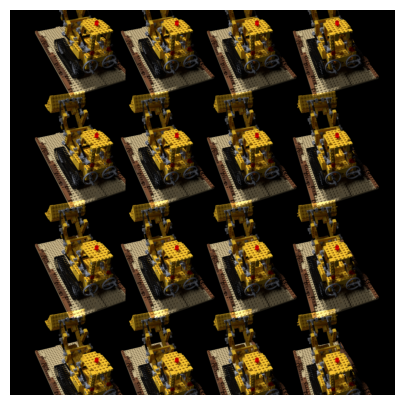

In [11]:
plt.figure(figsize=(20,5))
rgb_gt2 = copy.deepcopy(rgb_gt)
# rgb_gt2[520,:,:] = 1
plt.imshow(rgb_gt2)
plt.axis('off')

In [4]:
import multiplexing
import matplotlib.pyplot as plt
index = [2]
path = '/home/vitran/plenoxels/blender_data/drums'
neighbors = multiplexing.get_adjacent_views(index, path)

In [5]:
print(neighbors)
from PIL import Image

[194, 193, 195, 192, 196, 191]


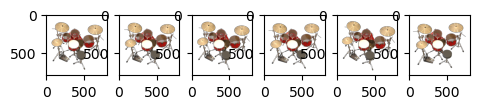

In [7]:
path = '/home/vitran/plenoxels/blender_data/drums/test'
for i, n in enumerate(neighbors):
    p = f'{path}/r_{n}.png'
    plt.subplot(1,len(neighbors)+1, i+1)
    plt.imshow(Image.open(p))